In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration


 94% 81.0M/85.8M [00:00<00:00, 107MB/s] 
100% 85.8M/85.8M [00:00<00:00, 94.1MB/s]


In [ ]:
!unzip nyc-taxi-trip-duration.zip

Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df = df.drop('dropoff_datetime', axis=1)
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df = df.sort_values(by='pickup_datetime')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [ ]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

<Axes: >

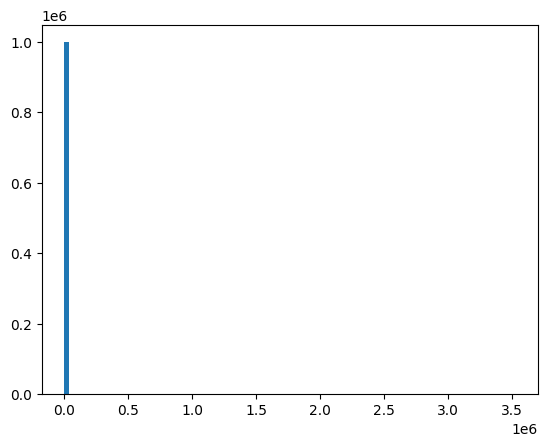

In [ ]:
df_train.trip_duration.hist(bins=100, grid=False, )

<ipython-input-13-b0443717f4d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
<ipython-input-13-b0443717f4d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)


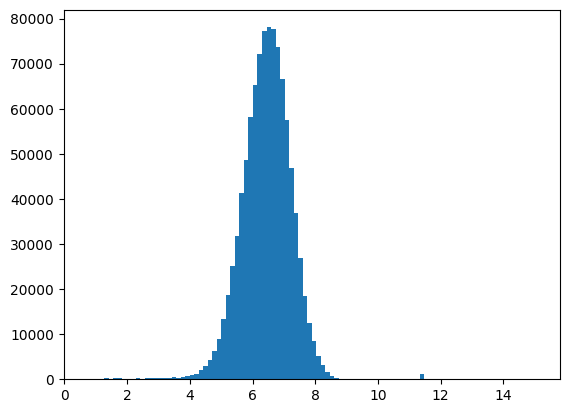

In [ ]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [ ]:
import datetime
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
  )

  return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [ ]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse_output=False),[1])], remainder="passthrough")
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [ ]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760848

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(100, 750, 10)},
                             cv=5).fit(X_train, y_train)

<ipython-input-34-c0d8cf959af5>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);


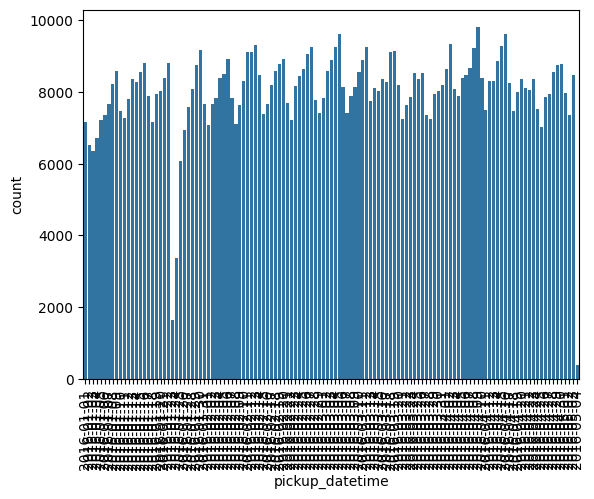

In [ ]:
#date_sorted = df_train.pickup_datetime.apply(lambda x: x.weekday).sort_values()
group_by_weekday = df_train.pickup_datetime.apply(lambda x: x.date())
date_count_plot = sns.countplot(
  x=group_by_weekday,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

<ipython-input-40-70b5b81fb23e>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);


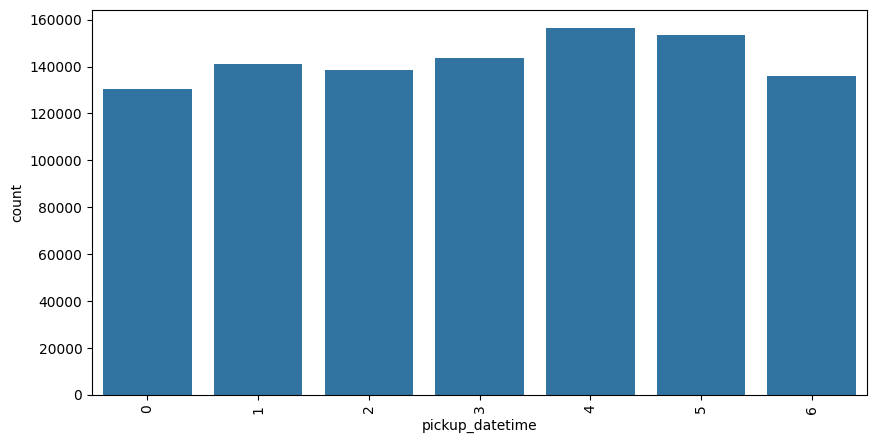

In [ ]:
group_by_weekday = df_train.pickup_datetime.apply(lambda x: x.weekday())
plt.figure(figsize=(10, 5))
date_count_plot = sns.countplot(
  x=group_by_weekday,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);
#sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

In [ ]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()
date_sorted
'''
plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);
'''

'\nplt.figure(figsize=(25, 5))\ndate_count_plot = sns.countplot(\n  x=date_sorted,\n)\ndate_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);\n'

In [ ]:
import datetime
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_wday),
      data_frame.pickup_datetime.apply(lambda x: 1 if x.weekday() in (1, 5) else 0),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day','weekday','anomaly', 'hour',]
  )

  return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
lin = LinearRegression()
l = lin.fit(X_train, y_train)
mean_squared_error(l.predict(X_test), y_test)

0.6503597810352368

In [ ]:
X_train.head()

,day,weekday,anomaly,hour
96469,1,4,0,0
223872,1,4,0,0
713067,1,4,0,0
652463,1,4,0,0
722901,1,4,0,0


In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse_output=False),[1, 3])], remainder="passthrough")

In [ ]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
X_train.shape

(1000000, 33)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

gid_searc = Lasso(alpha=2.6 * 10**(-5))

gid_searc.fit(X_train, y_train)
mean_squared_error(gid_searc.predict(X_test), y_test)

0.6504025837332407

In [ ]:
gid_searc.coef_[gid_searc.coef_> 10*(-6)]

array([-6.34913713e-02,  0.00000000e+00,  9.15342135e-03,  3.05261311e-02,
        1.02400593e-02, -7.00809687e-02, -1.13325883e-01, -2.18874496e-02,
       -5.25596994e-02, -8.82076852e-02, -8.88057219e-02, -9.05671653e-02,
       -2.02023351e-01, -2.73482048e-01, -1.19758501e-01, -8.43876102e-03,
        1.20300889e-02,  1.82622096e-02,  4.89497166e-02,  5.21059625e-02,
        6.76822600e-02,  9.14608081e-02,  9.79586400e-02,  7.02513178e-02,
        6.53625590e-02,  3.74490968e-02, -2.01972020e-02, -3.58947275e-02,
       -2.93435647e-02,  1.23637443e-07,  9.83968038e-04,  7.94450996e-04,
       -0.00000000e+00])